<a href="https://colab.research.google.com/github/Snrts/PRA3024_BigDataInPhysics_SanneAarts/blob/main/SanneAartsGW2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import sys
!{sys.executable} -m pip install lalsuite==7.11 pycbc 
%pip install gwpy
%pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
# Data 
import numpy as np
import pandas as pd
import numba 
from numba import jit
from scipy.stats import norm

# Plotting and display
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import pylab

# Constants
from astropy.constants import M_sun

# gwpy
import gwpy
# from gwpy.timeseries import TimeSeries

# pycbc
import pycbc
from pycbc import catalog
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t, matched_filter, highpass_fir, lowpass_fir, sigma, match, sigmasq
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation, welch, aLIGOZeroDetHighPower, EinsteinTelescopeP1600143
from pycbc.types import TimeSeries
from pycbc.inference.io import loadfile

from gwosc.datasets import find_datasets, event_gps, run_segment
from gwosc import datasets

#lal
import lal
import lalsimulation
import lalframe 

ImportError: ignored

# Exercise 1
## Part 1

Download the data set from [[1]](https://drive.google.com/file/d/1-TP16GA9Pe0lM6isKu9ByaGtqBIU9pns/view) . This data set contains a noise time series and an addi-
tional gravitational wave signal, where the sampling rate of the time series is 16384Hz.
The first column of the data set refers to the time. The second and third columns
are the data recorded by LIGO Hanford and Livingston, respectively. For the sake of
convenience in data analysis, we downsample the data at a sampling rate of 2048Hz

In [13]:
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



In [23]:
merger = Merger("GW170817")

In [46]:
@jit(forceobj=True)
def handleData():
  myvars = vars()
  merger = Merger("GW170817")
  for i in ["H1", "L1"]:
    # Reading the fataframe
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(i[0], i),
                    '{}:LOSC-STRAIN'.format(i),
                  start_time=merger.time - 224,
                  end_time=merger.time + 32,
                  check_integrity=False)
    # Resampling the data to 2048 Hz, and cropping away the artifacts
    strain = resample_to_delta_t(highpass(ts, 15), 1/2048)
    conditioned = strain.crop(4,4)
    #creating a frequency series
    fs = conditioned.to_frequencyseries()
    #Determining the parameters needed to calculate rhe power spectrum density
    delta_t = conditioned.delta_t
    len = int(2/delta_t)
    #Using the Welch method to estimate the PSD
    psd = interpolate(welch(conditioned,len,int(len/2)), fs.delta_f)
    #Storing the timeseries, frequencyseries and the PSD in a dictionary that is passed to the 
    #corresponding variable
    myvars.__setitem__(i, {"m":conditioned, "fs": fs ,"psd":psd})
  return myvars

data = handleData()
H1, L1 = data["H1"], data["L1"]

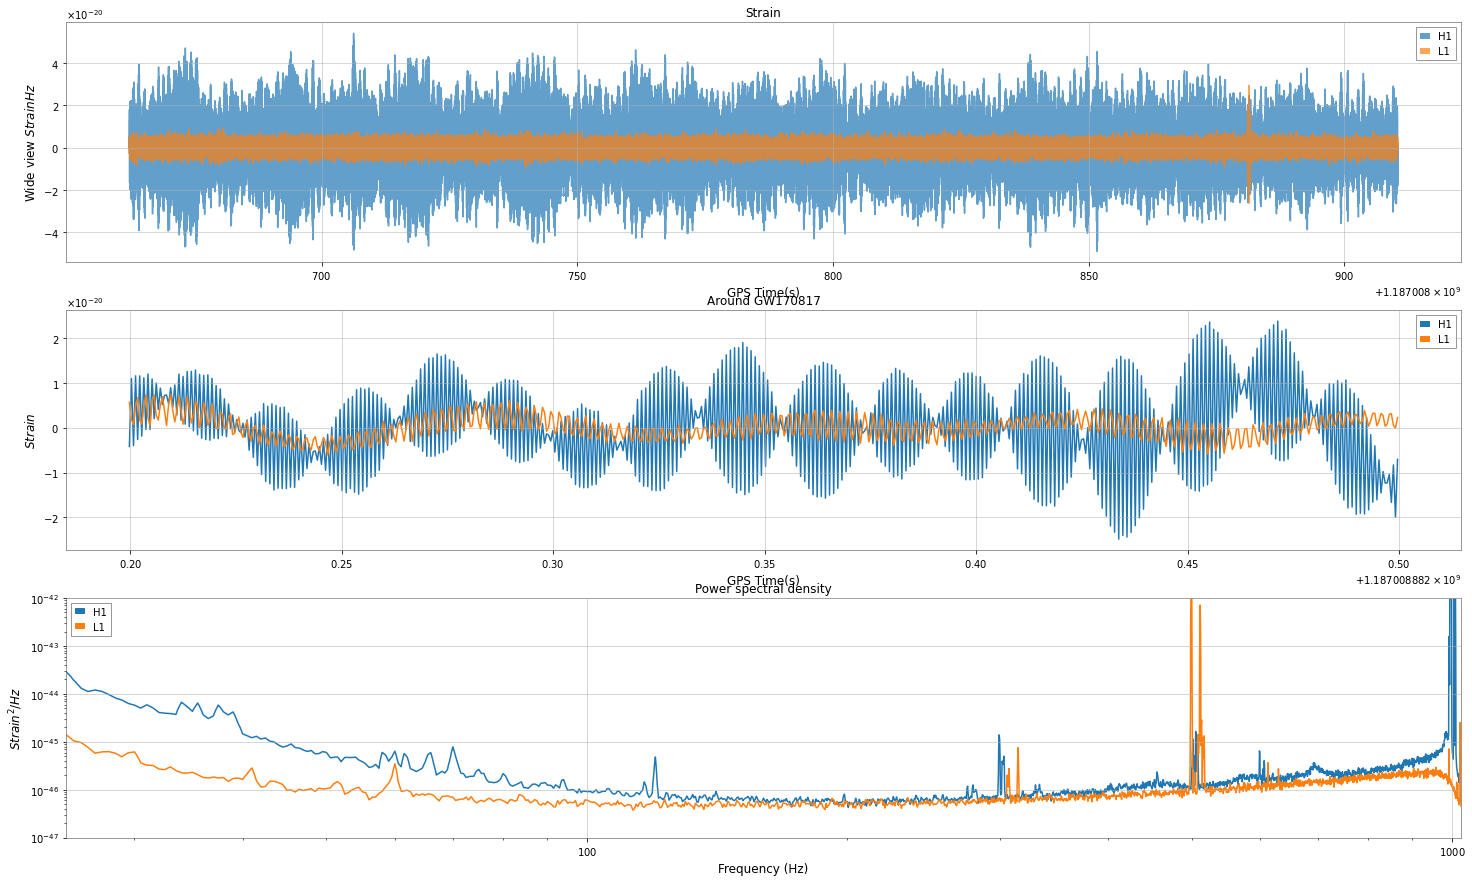

In [26]:
#plotting the strain vs the time in a wide view and again zoomed in
#plotting the psd against the frequencies
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(25,15), nrows=3)
for i in ["H1", "L1"]:
    ax1.plot(data[i]["m"].sample_times, data[i]["m"], label=i, alpha=0.7)
    ax2.plot(data[i]["m"].time_slice(merger.time - 0.2, merger.time+0.1).sample_times, data[i]["m"].time_slice(merger.time - 0.2, merger.time+0.1), label=i)
    ax3.loglog(data[i]["psd"].sample_frequencies, data[i]["psd"], label=i)

ax1.set_ylabel('Wide view $Strain Hz$')
ax1.set_xlabel('GPS Time(s)')
ax1.set_title("Strain")
ax1.legend()

ax2.set_ylabel('$Strain$')
ax2.set_xlabel('GPS Time(s)')
ax2.set_title("Around GW170817")
ax2.legend()

ax3.set_xlim(25, 1024)
ax3.set_ylim(1e-47, 1e-42)
ax3.legend()
ax3.set_ylabel('$Strain^2 / Hz$')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_title("Power spectral density")
plt.legend()    
plt.show()

## Part 2

Write down the code to calculate the matched filter between the given data and a
template waveform. After that, find out the template waveform for which the signal
to noise ratio is maximum. For simplicity, you can assume the template waveform is
produced from an equal mass binary system. Produce a plot which shows the SNR
versus total mass of the system, where masses of the systems are uniformly distributed
in a range 1M ≤ m1,2 ≤ 3M (use m1 = m2). Represent the result by fitting the
best match template waveform against the data. Also, show the chirp structure of the
signal over the time-frequency domain using Q-transformation().

We are given that $m_1=m_2=m$ where $1\hspace{0.2em} M_\ \leq m \leq 3\hspace{0.2em}M_⊙$



We found the best match for the mass was 1.3800000000000003 $M_⊙$ (detector frame)


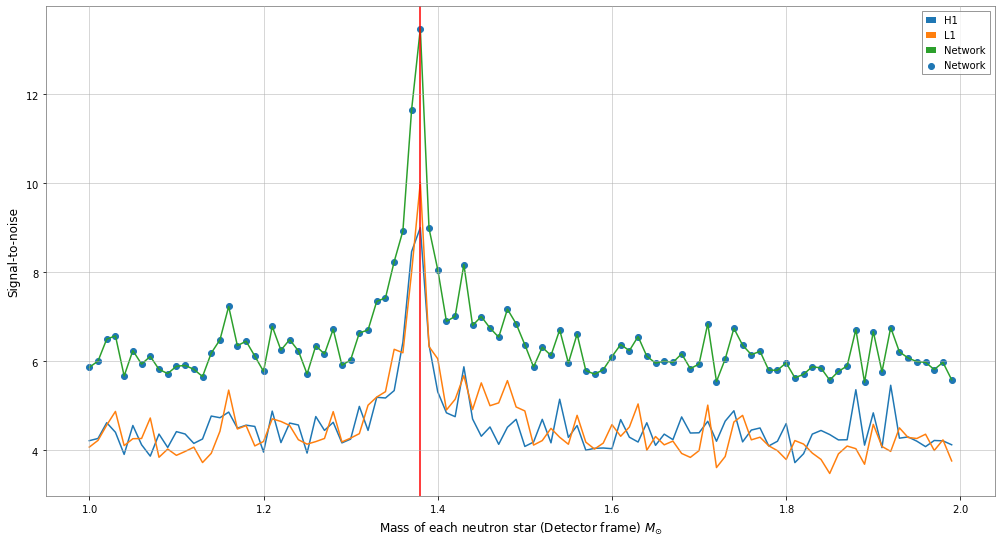

In [47]:
#Function that generates a waveform based on the mass parameter
#since we are matching the template to a dataset we resize it to match the length
@jit(forceobj=True) 
def waveform(m):
  hp, hc = get_fd_waveform(approximant="TaylorF2", 
                             mass1=m, mass2=m, 
                             f_lower=20, delta_f=data[i]["fs"].delta_f)
    
  hp.resize(len(data[i]["fs"]))
  return hp
# Function that finds the maximum snr for a given template and the corresponding time
@jit(forceobj=True)  
def findSnr(m):
  template = waveform(m)

  snr_max, time_max = {}, {}

  for i in ["H1","L1"]:
    snr = matched_filter(template, 
                        data[i]["fs"], 
                        psd=data[i]["psd"], 
                        low_frequency_cutoff = 25)
    snr = snr.time_slice(merger.time - 1, merger.time + 1)
    _ , idx = snr.abs_max_loc()
    snr_max[i] = snr[idx]
    time_max[i] = float(idx)/snr.sample_rate + snr.start_time

  return snr_max, time_max, template

# Function the finds the overall maximum snr and determines the corresponding parameters
@jit(forceobj=True)  
def findMax(): 
  myvars = vars()
  masses = np.arange(1,2,0.01)
  hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
  snrs = []
  h1 = []
  l1 = []
  for m in masses:
    snr_max, time_max, template = findSnr(m)
    network_snr = abs(np.array(list(snr_max.values()))**2.0).sum()**0.5
    h1.append(abs(snr_max["H1"]))
    l1.append(abs(snr_max["L1"]))
    snrs.append(snr_max)

    if network_snr > nsnr:
      hmax =  template
      smax = snr_max
      tmax = time_max 
      mmax = m
      nsnr = network_snr

  print(f"We found the best match for the mass was {mmax} $M_⊙$ (detector frame)") 
  # Plots the Graph for the H1 data, the L1 data and their combinatin
  fig = plt.figure(figsize=(17,9))
  plt.plot(masses, h1, label="H1")
  plt.plot(masses, l1, label="L1")
  plt.plot(masses, [abs(np.array(list(s.values()))**2.0).sum()**0.5 for s in snrs],label = "Network")
  plt.scatter(masses, [abs(np.array(list(s.values()))**2.0).sum()**0.5 for s in snrs],label = "Network")
  plt.axvline(x=mmax, color='r', linestyle='-')
  plt.ylabel('Signal-to-noise')
  plt.xlabel('Mass of each neutron star (Detector frame) $M_⊙$')
  plt.legend()
  plt.show()

findMax()


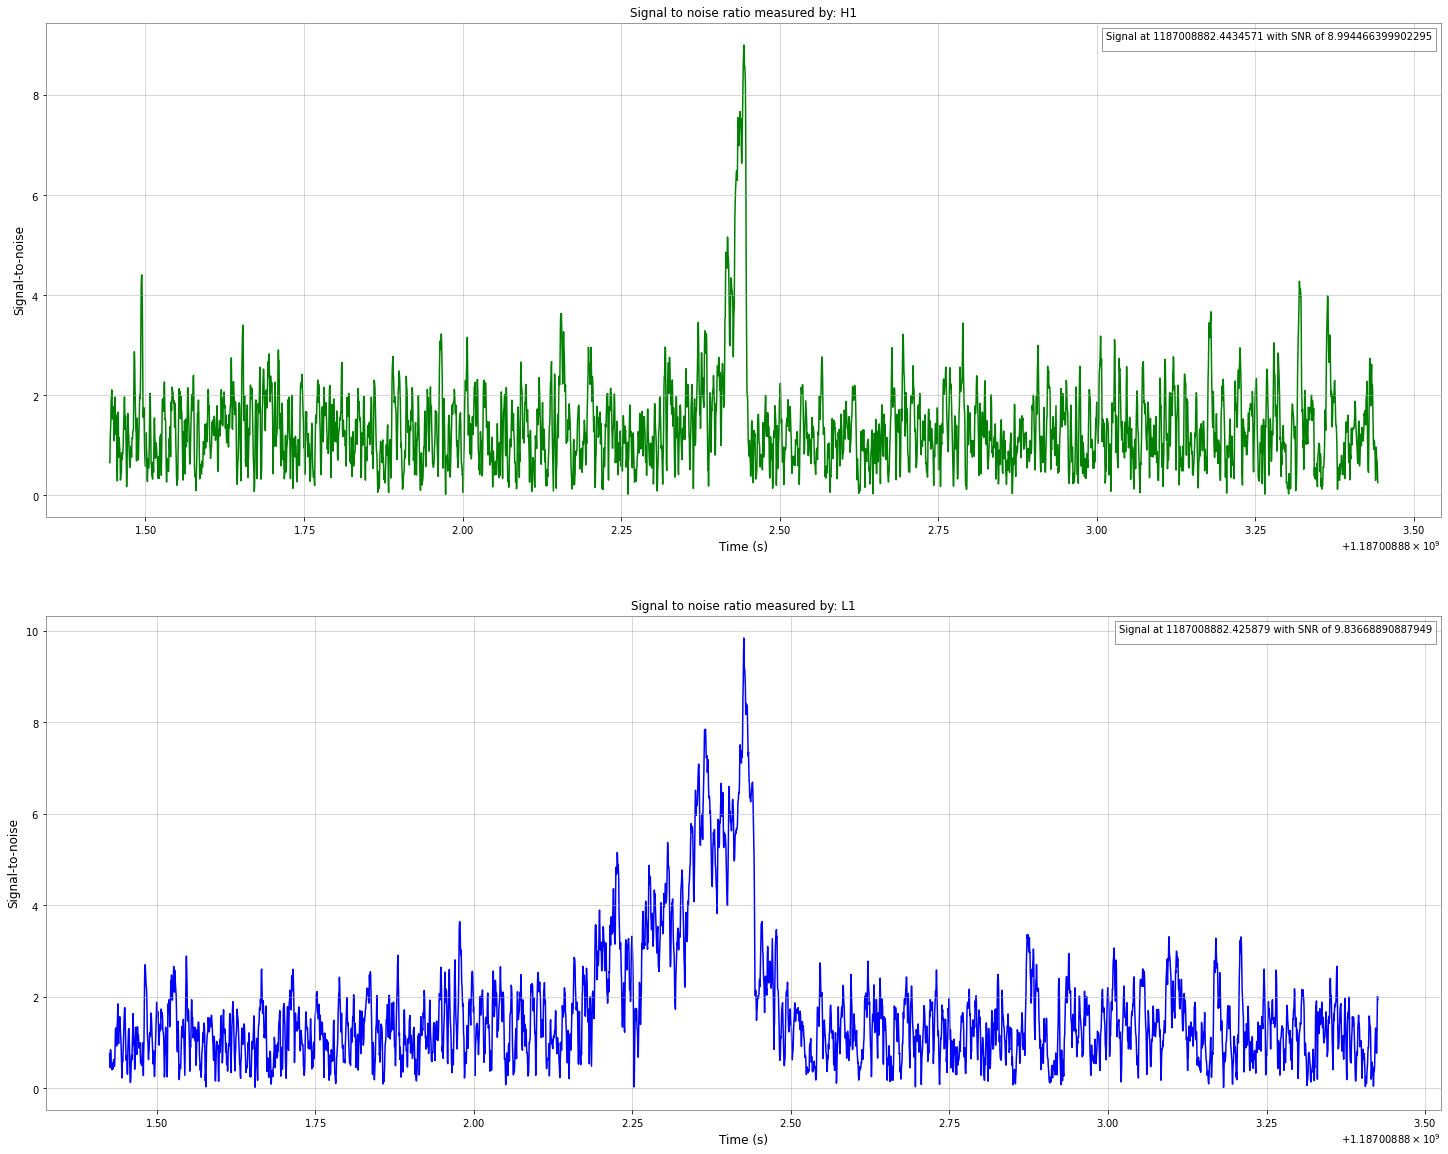

In [33]:
snr ={}
def findPeak(i):
  snr[i] = matched_filter(waveform(1.38), data[i]["m"], psd=data[i]["psd"], low_frequency_cutoff=20)
  snr[i] = snr[i].crop(4+4,4)
  
  peak = abs(snr[i]).numpy().argmax()
  snrp = snr[i][peak]
  time = snr[i].sample_times[peak]
 
  return peak, snrp, time


fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(25,20))
for i, a, c in zip(["H1", "L1"], [ax1,ax2], ["g", "b"]):
  p,s,t = findPeak(i)
  a.plot(snr[i].time_slice(t-1, t+1).sample_times, abs(snr[i].time_slice(t-1, t+1)), color=c)
  a.set_ylabel('Signal-to-noise')
  a.set_xlabel('Time (s)')
  a.set_title(f'Signal to noise ratio measured by: {i}')
  st = f"Signal at {t} with SNR of {abs(s)}"
  a.legend(title="".join(st))
pylab.show()
  

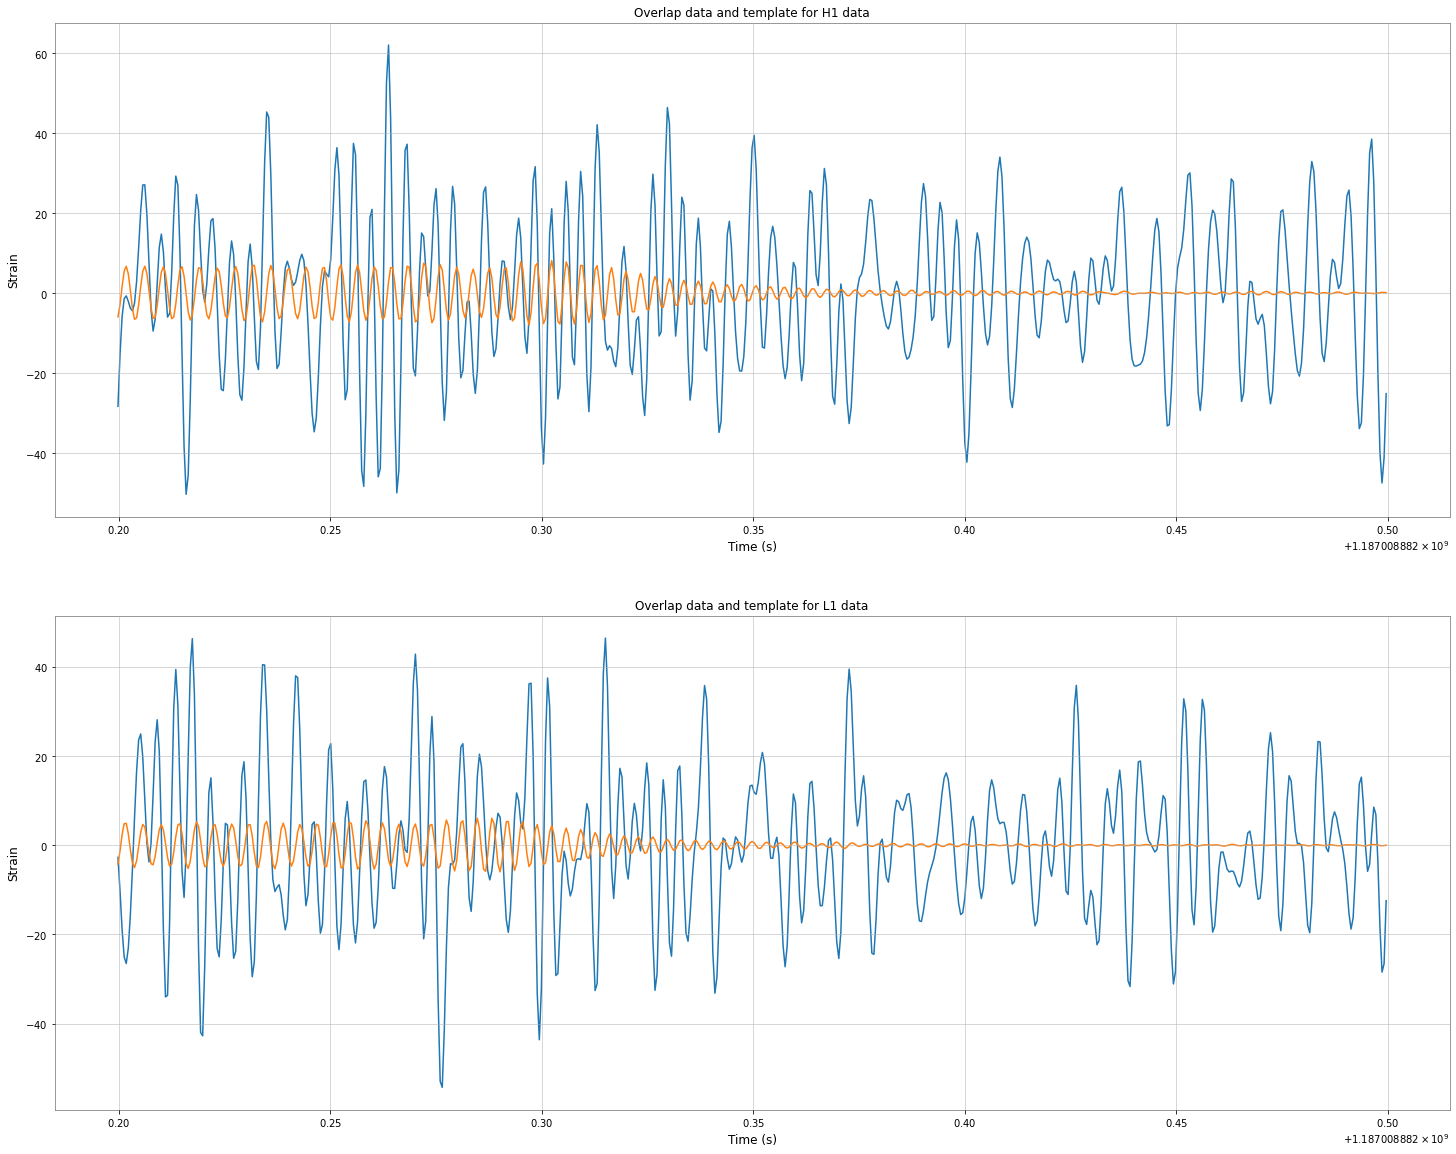

In [48]:
@jit(forceobj=True)
def whiten(i):
    merger = Merger("GW170817")
    p,s,t = findPeak(i)
    dt = t- data[i]["m"].start_time

    aligned = waveform(1.38).cyclic_time_shift(dt)
    aligned /= sigma(aligned, psd=data[i]["psd"], low_frequency_cutoff=20.0)
    aligned = (aligned.to_frequencyseries()*abs(s)).to_timeseries()
    aligned.start_time = data[i]["m"].start_time
    
    white_data=(data[i]["m"].to_frequencyseries()/data[i]["psd"]**0.5).to_timeseries()
    tapered = aligned.highpass_fir(30,512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries()/data[i]["psd"]**0.5).to_timeseries()
    
    white_data=white_data.highpass_fir(30,512).lowpass_fir(300,512)
    white_template=white_template.highpass_fir(30,512).lowpass_fir(300,512)
    
    white_data=white_data.time_slice(merger.time-.2, merger.time+.1)

    white_template = white_template.time_slice(merger.time-.2, merger.time+.1)
    return white_data, white_template, aligned
    

fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(25,20))
for i, a in zip(["H1", "L1"], [ax1,ax2]):
  wd, wt, _ = whiten(i)
  a.plot(wd.sample_times, wd,label="Data")
  a.plot(wt.sample_times, wt,label="Template")
  a.set_ylabel('Strain')
  a.set_xlabel('Time (s)')
  a.set_title(f'Overlap data and template for {i} data')
pylab.show()

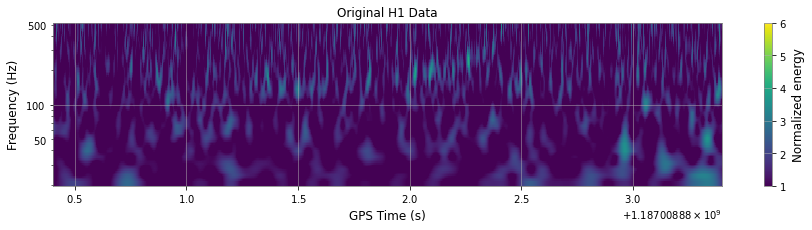

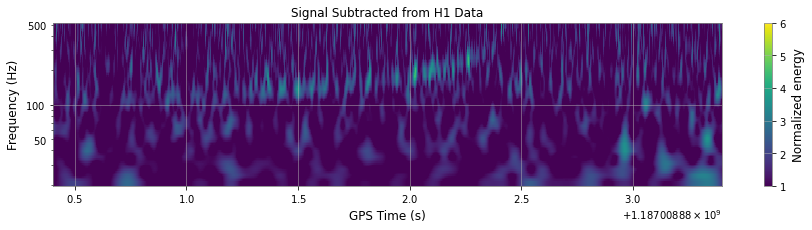

In [42]:
@jit(forceobj=True)
def plotq(i):
  # fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=2, figsize=(15, 20))
  merger = Merger("GW170817")
  wd,wt, aligned = whiten(i)
  subtracted = data[i]["m"]-aligned
  for d ,title in [(data[i]["m"], 'Original H1 Data'),
                  (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = d.whiten(4, 4).qtransform(.001,
                                            logfsteps=100,
                                            qrange=(8, 8),
                                            frange=(20, 512))
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('GPS Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(merger.time - 2, merger.time + 1)
    pylab.colorbar(cmap='viridis', label='Normalized energy') #adding a colorbar with the label    
    pylab.show()

plotq("H1")

## Part 3
Here, we would like to investigate the correlation in the parameter space of gravita-
tional waves from compact binary coalescences. Let us consider a gravitational wave
h∗(t; m1,m2) generated from a binary with masses m1 = m2 = 10M . Now, we want
to understand how the nearby templates are correlated with that waveform. Calculate
the match between h∗(t; m1,m2) and the nearby templates that are generated assum-
ing 5M ≤ m1,m2 ≤ 15M . Of course, one should have the maximum match (= 1)
when hi = h∗. You will see that the match between two nearby waveforms is not zero.
So, one can realize the gravitational waveforms are correlated for two nearby points
in the parameter space. This fact is used to produce a template bank for detecting
gravitational waves.

Text(0, 0.5, 'Match')

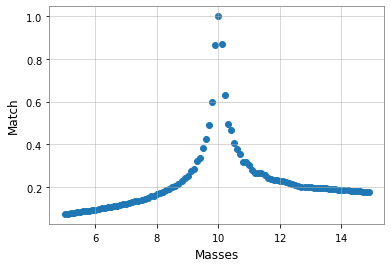

In [49]:
def waveforms(m):
  hp, hc = get_td_waveform(approximant="TaylorT2", 
                            mass1=m, 
                            mass2=m, 
                            delta_t=1/4096,
                            f_lower=30)
  return hp

def getTemp(masses):
  hp,_ = get_td_waveform(approximant="TaylorT2",
                         mass1=10, 
                         mass2=10,
                         delta_t=1/4096,
                         f_lower=30)
 
  toCheck = [waveforms(m) for m in masses]
  tlen = max(np.maximum(len(hp), [len(h) for h in toCheck]))
  for h in toCheck:
    h.resize(tlen)
  return hp, tlen, toCheck

def corr(m):
  hp, tlen, templates = getTemp(m)
  m_val = []
  flen = tlen//2 + 1
  flow = 30
  tc = [{"h": h, "psd":aLIGOZeroDetHighPower(flen, 1/h.duration, flow),"low_frequency_cutoff":flow} for h in templates]
  hp.resize(tlen)
  for i in tc:
    p,i = pycbc.filter.match(hp, i["h"], i["psd"],low_frequency_cutoff=i["low_frequency_cutoff"])
    m_val.append(p)
  return m_val
m = np.arange(5,15,0.1)
plt.scatter(m, corr(m))
plt.xlabel("Masses")
plt.ylabel("Match")

# Exercise 2
## Part 1

Load the data of the LIGO Hanford detector from [2]. Plot the noise power spectral
density (PSD) of that data. Test whether there is any gravitational wave signal present
in the data or not? For this test, you can assume the GW signals can produce only
from equal mass binary systems with a range between 5 to 10. We assume a threshold
on matched filter SNR of 8 to claim detection of GW.

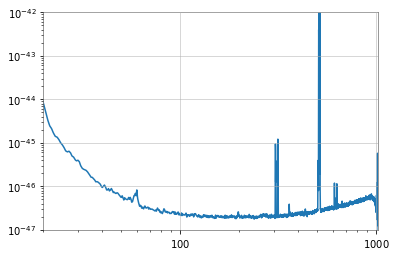

In [52]:
@jit(forceobj=True)
def handleData2():
  d = np.load('/content/drive/MyDrive/noise_ts_4096Hz.npy')
  dt = d[:, 0]
  
  d = TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
  data = d
  conditioned = resample_to_delta_t(highpass(data, 15.0), 1.0/2048).crop(4,4)
  fs = conditioned.to_frequencyseries()

  delta_t = conditioned.delta_t
  seg_len = int(2/delta_t)
  seg_stride = int(seg_len/2)
  psd = welch(conditioned,
              seg_len= seg_len,
              seg_stride= seg_stride)
  psd = interpolate(psd, fs.delta_f)
  
  plt.loglog(psd.sample_frequencies, psd)
  pylab.xlim(20, 1024);
  pylab.ylim(1e-47, 1e-42);
  return {"m":conditioned, "fs": fs ,"psd":psd}
  
H12 = handleData2()

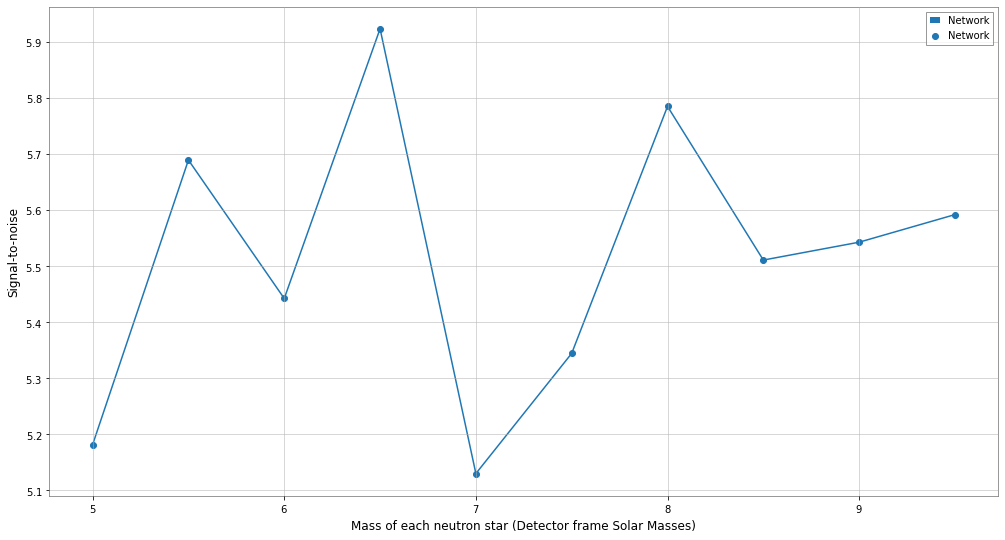

In [53]:
@jit(forceobj=True) 
def waveform(m, H1):
  hp, hc = get_fd_waveform(approximant="TaylorF2", 
                             mass1=m, mass2=m,
                            delta_f=H12["fs"].delta_f ,
                             f_lower=15)
  hp.resize(len(H12["fs"]))
  hp.cyclic_time_shift(hp.start_time)
  return hp

@jit(forceobj=True) 
def getTemp(mass, H1):
  waveforms = [waveform(m,H1) for m in mass]
  snrps = []
  
  for i in waveforms:
    snr = matched_filter(i, H12["fs"], H12["psd"],low_frequency_cutoff=15)
    snr = snr.crop(4+4,4)
    snrps.append(max(abs(snr)))
  return snrps

fig = plt.figure(figsize=(17,9))
masses = np.arange(5,10,0.5)
y = getTemp(masses, H1)
plt.plot(masses, y,label = "Network")
plt.scatter(masses,y,label = "Network")
plt.ylabel('Signal-to-noise')
plt.xlabel('Mass of each neutron star (Detector frame Solar Masses)')
plt.legend()
plt.show()

## Part 2
Whiten the above data using its noise PSD. You can use PyCBC based function of the
Welch method to estimate the PSD. Construct a histogram of the whitened data and
show that the whiten data follows a Gaussian distribution with zero mean. 

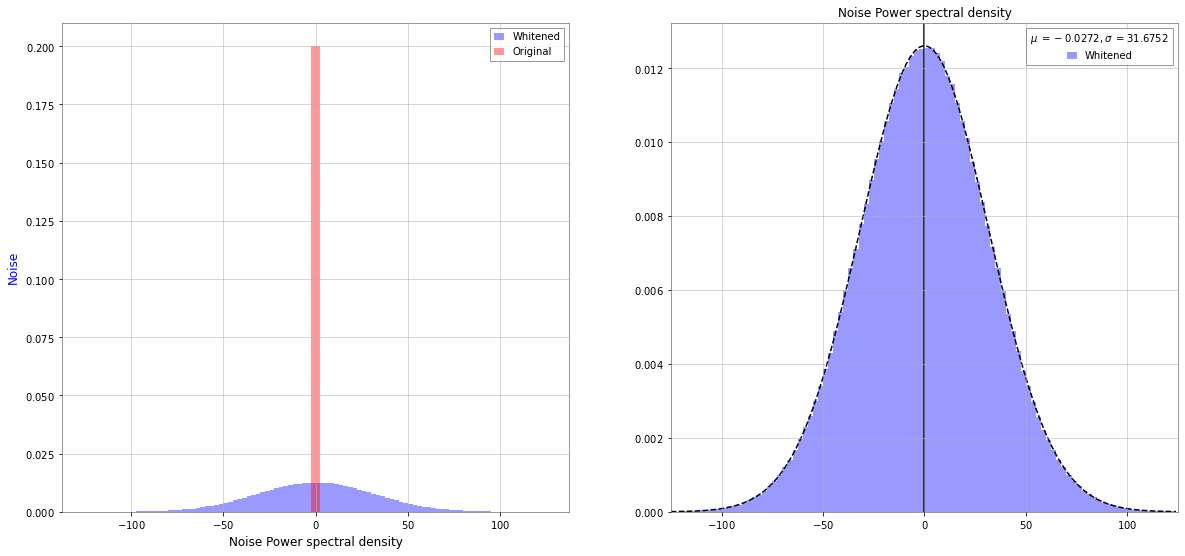

In [56]:
white_data = (H12["m"].to_frequencyseries()/H12["psd"]**0.5).to_timeseries()
white_data = white_data.crop(4,4)

mean = np.mean(white_data)
std = np.std(white_data)
x = np.arange(-125,125)

fig, (ax1, ax2) = plt.subplots(figsize=(20,9),ncols=2)
ax1.set_xlabel('Noise Power spectral density')
ax1.set_ylabel('Noise', color="b")
ax1.hist(white_data, bins=100, range =(-125,125), color="b", alpha=0.4, label ="Whitened", density = True);
ax1.hist(H12["m"], bins=100, range =(-125,125), color="r", alpha=0.4, label ="Original", density = True);
ax1.legend()

ax2.set_xlim((-125,125))
plt.title("Noise Power spectral density")

ax2.hist(white_data, bins=100, range =(-125,125), color="b", alpha=0.4, label ="Whitened", density=True);

ax2.plot(x,norm.pdf(x,mean, std),color='k', ls="--")
ax2.axvline(0, c='k')

ax2.legend(title="".join(f'$\mu\ = {round(mean,4)}, \sigma\ ={round(std, 4)}$'))
plt.show()

## Part 3
n gravitational wave data analysis, we consider that the noise is stationary Gaussian.
But in reality, the stationary assumption does not hold. Can you think of a test to
show that the stationarity does not hold?
[To devise this test, you can consider the above data. Take a arbitrary gravitational
waveform h(f) and calculate the optimal SNR $\rho_{opt}$
$$\rho^2_{opt}=4\int \frac{ | h(f) |  ^2}{S_n(f)}df$$

where $S_n(f)$ is noise power spectral density of the data. For the test, you can consider
different chunk of data

In [63]:
seg_dur = 4
seg_overlap = 2
chunk_duration = 32
n_chunks =  int(np.ceil(white_data.duration / chunk_duration))
psd = estimate.interpolate(white_data, seg_duration, seg_overlap)

df = white_data.sample_rate / white_data.size
f = np.arange(data.size / 2 + 1) * df
hp, hc = get_fd_waveform(approximant="TaylorF2",
                        mass1=3,
                        mass2= 3, 
                        delta_f=df,
                        distance = 500,
                        f_lower=20.0,
                        f_final = 2048)

snrs = []
for i in range(n_chunks):
    # Extract the chunk of data
    t_start = i * chunk_duration
    t_end = (i + 1) * chunk_duration
    chunk = white_data.time_slice(t_start, t_end)

    # Calculate the SNR
    rho = sigma(h, chunk, psd=psd, low_frequency_cutoff=20)
    snrs.append(rho)

snrs

NameError: ignored

# Exercise 3
## Part 1
he horizon distance of a GW detector is defined as a distance to the source for which
the accumulated signal power (optimal SNR) is equal to a detection threshold of SNR
($\rho_{min}$ = 8) when the source is located overhead (θ = 0,π). Plot the horizon distance
for Advanced LIGO detector (assuming ’H1’ noise PSD) assuming a set of equal mass
binary with a range of component masses between 5 to 500. In this plot, you can
assume that X-axis and Y-axis represent the total mass of the binary and horizon
distance, respectively. For this analysis, first, generate the GW waves polarization in
frequency domain, h+(f),h×(f) and construct the projection detector frame, $$h(f) =
F_+h_+(f) + F_×h_×(f)$$
here $F_+$ and $F_×$are the antenna pattern functions for the two
polarizations. Using the sky location (θ,φ) and polarization angle of the incoming GW,
one can show that for ‘L’ shaped detector $F+,F×$can be written as
$$F_+ = \frac{1}{2}(1 + cos^2θ)cos 2φcos 2ψ −cos θ sin 2φsin 2ψ$$
$$F_x = \frac{1}{2}(1 + cos^2θ)cos 2φcos 2ψ - cos θ sin 2φsin 2ψ$$

N.b. The maximum values of $F_+,F_×$ is 1.

In [58]:
def getdistances(m,d,psd,delta_f,flow):
  hp, hc = get_fd_waveform(approximant="TaylorF2", 
                         mass1=m, 
                         mass2=m, 
                         delta_f=delta_f , 
                         distance = d,  
                         f_lower=flow)
  return (sigmasq(hp,psd))**0.5

flow = 4.0
delta_f = 1.0/16
flen = int(2048.0/(delta_f))+1
snr_thres = 8
d = 1
masses = np.arange(5,500,1)

def plot(psd):
    psd.data[:int(flow/delta_f)]=np.inf
    psd.data[-1]=np.inf

    fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,10))
    ax1.loglog(psd.sample_frequencies, psd)
    ax1.set_xlabel("Freq (Hz)")
    ax1.set_ylabel("PSD($m/s)^2$/Hz)")
    ax1.set_title("Model PSD")
    ax1.set_ylim()
    ax2.plot(2*masses,[d*getdistances(m,d,psd,delta_f,flow)/snr_thres for m in masses])
    ax2.set_xlabel("$Total Mass(m_1+m_2) (M_⊙)$")
    ax2.set_ylabel("Horizon Distanc (Gpc)")
    ax2.set_title("Horizon Distance estimate")

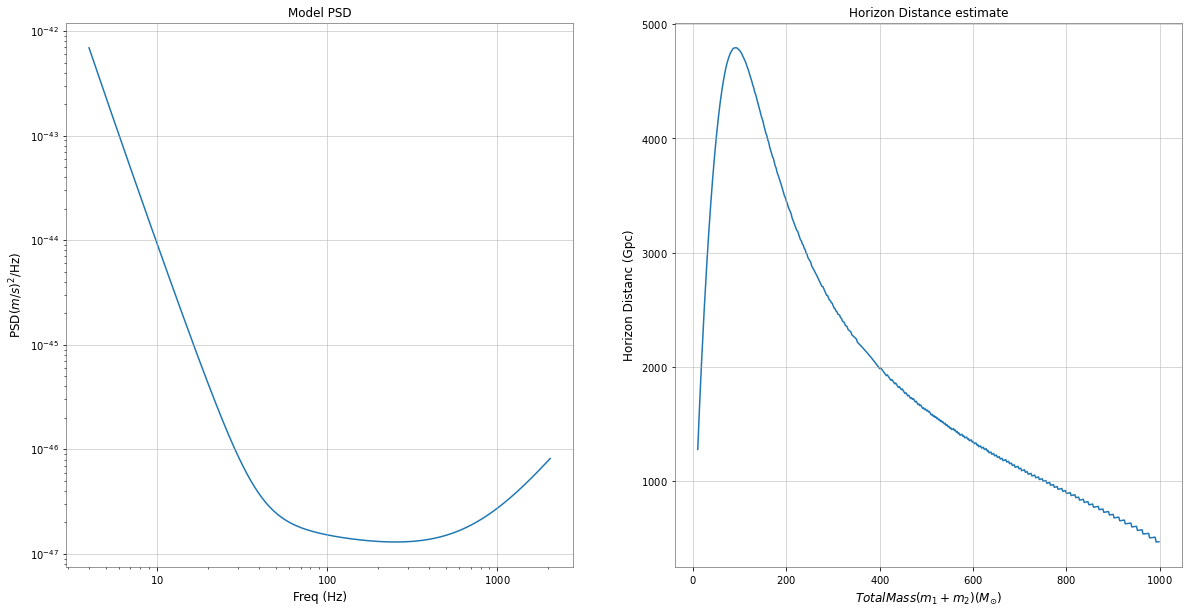

In [59]:
psdl = aLIGOZeroDetHighPower(flen, delta_f, flow)
plot(psdl)

## Part 2
From the plot of horizon distance, you will see the curve reaches its maximum value for
a massive black hole. After that, the horizon distance decreases over mass. Can you
explain why do we see such behavior? What can you interpret from the point of view
of the detector’s capability to detect GWs from the compact binary merger?

## Part 3
Repeat the same analysis for the future generation gravitational wave detectors (Ein-
stein telescope) and make a plot for horizon distance versus the total mass of the system.
Compare this plot with the previous plot for the Advanced LIGO detector and make
your conclusion.

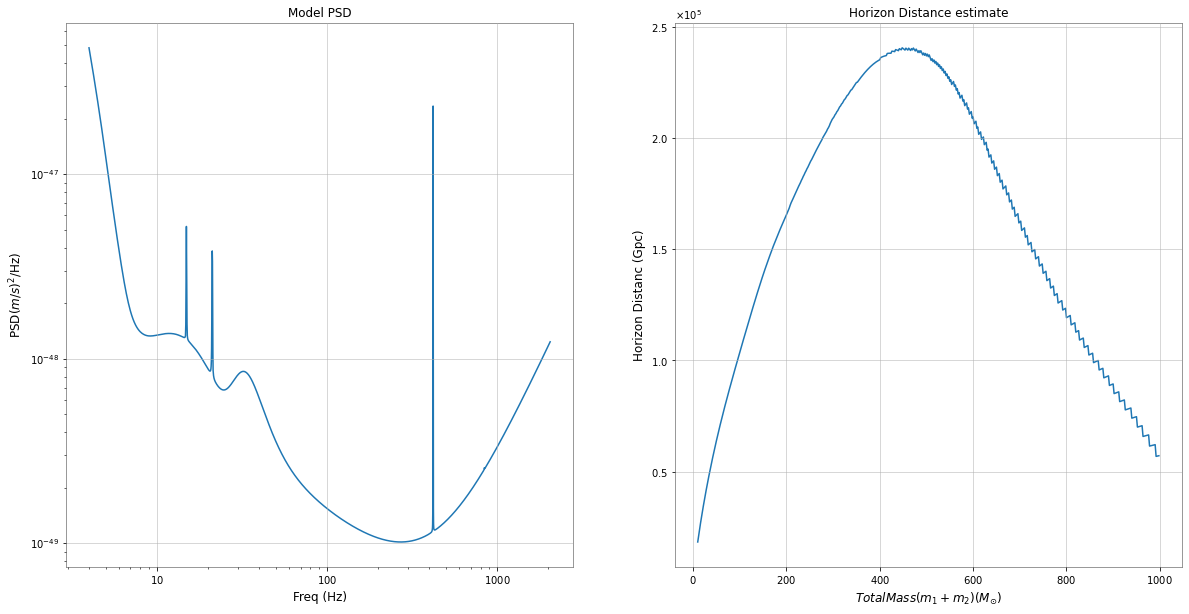

In [60]:
psde = EinsteinTelescopeP1600143(flen, delta_f, flow)
plot(psde)